<h1>
Exercício 3
</h1>
<h2>
Previsão do valor máximo para a recomendação de crédito para os analistas.
</h2>

# Bibliotecas

In [38]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [2]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

def plot_history(history):
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.ylim(0,1500000000)
    plt.plot(x, mse, 'b', label='MSE Treino')
    plt.plot(x, val_mse, 'r', label='MSE Validação')
    plt.title('Treino e Validação - MSE')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.ylim(0,50000)
    plt.plot(x, loss, 'b', label='Loss Treino')
    plt.plot(x, val_loss, 'r', label='Loss Validação')
    plt.title('Treino e Validação - Loss')
    plt.legend()

# Carregando os Dados
## dados pré processados no notebook de análises de dados

In [3]:
df = pd.read_csv("./df_pre_processado.csv")

In [4]:
df.head(10)

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.00000,43200.0,2020-02-03T20:57:33
1,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.00000,4320.0,2020-02-04T16:40:49
2,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.00000,89000.0,2020-02-04T15:06:28
3,7,Alexander Baker-Wells,Dr. Caroline Ali,PYOL43118620147076,16,0.000000,NaN,2011-03-02T11:27:13,0,0.00,...,12.0,156394112.0,1982.0,Acima de 17 anos,30515674.0,True,False,0.00000,18132588.0,2020-02-05T14:31:22
4,8,Jean Berry,Gregory Gould,NLUX93496216176463,4,0.350175,0.0,2007-07-02T00:00:00,102,208980.00,...,9.0,0.0,2000.0,Acima de 17 anos,120000.0,False,False,1.00000,768233.0,2020-02-05T20:05:40
5,9,Elliot Stephenson,Adrian Graham,LOVL82962402474134,43,0.245818,0.0,2006-07-10T00:00:00,27,6432.00,...,12.0,-49267738.0,2000.0,Acima de 17 anos,1000000.0,False,False,1.00000,6910219.0,2020-02-05T20:07:07
6,10,Dr. Dale Dawson,Caroline Hale,NXKJ36775578171965,24,0.000012,0.0,2011-02-24T00:00:00,0,22733.33,...,12.0,15322217.0,1996.0,Acima de 17 anos,80000.0,False,True,0.83159,635270.0,NaN
7,11,Katie Lawson,Patricia Reynolds,SVXA16230297135119,7,0.000000,NaN,2012-02-24T16:01:26,0,0.00,...,6.0,-3299332.0,2011.0,De 6 a 10 anos,20000.0,False,True,0.00000,81000.0,2020-02-05T15:15:10
8,12,Ellie Turner,Mohamed Welch,ELQK41348591516215,26,0.000000,NaN,2017-12-20T17:03:32,0,0.00,...,12.0,-9455401.0,2009.0,De 11 a 16 anos,600000.0,False,False,0.00000,183509.0,NaN
9,14,Nicole Fry,Lewis Harris,PVQV57475295829119,52,0.000000,NaN,2006-05-01T13:18:05,0,0.00,...,9.0,3366929.0,2003.0,Acima de 17 anos,88000.0,False,True,0.00000,739395.0,NaN


<h3>
Nesta análise vamos usar a variável "valorAprovado" como target para a regressão.<BR>
Portanto vamos trabalhar apenas com os dados que possuem este valor, ou seja, os clientes que tiveram o seu crédito aprovado.<BR>
</h3>

In [5]:
df = df[~(df.valorAprovado.isnull())]

<h3>
Vamos retirar agora as variáveis categóricas e de data que não serão utilizadas para este modelo de regressão.<BR>
Vamos tambem retirar algumas outras varáveis:<BR>
1) numero_solicitação - não necessitamos de um index.<BR>
2) percentualProtestos - esta variável náo ajuda a explicar o problema pois possue 83% de zeros e 16,7% de nulos. Sobrando apenas 0,3% de dados válidos.<BR>
3) diferencaPercentualRisco - mesmos valores do percentualRisco.<BR>
4) dashboardCorrelacao - Não entedemos o seu objetivo.<BR>
5) As duas booleanas - 'restricoes', 'empresa_MeEppMei'<BR>
</h3>

In [6]:
df_num = df.drop(['cnpjSemTraco', 'dataAprovadoEmComite', 'percentualProtestos', 'dataAprovadoNivelAnalista', 'numero_solicitacao', 'razaoSocial', 'nomeFantasia', 'anoFundacao', 'status', 'definicaoRisco', 'diferencaPercentualRisco', 'dashboardCorrelacao',
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses', 'restricoes', 'empresa_MeEppMei'], axis=1)

In [7]:
df_num.shape

(5095, 20)

In [8]:
explore(df_num)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
maiorAtraso,int64,5095,0,0.0,149,0.0,3.000,8.000,2.500000e+01,9.770000e+02,2.700400e+01,8.000,6.586500e+01,7.903
margemBrutaAcumulada,float64,5095,0,0.0,1168,0.0,0.292,0.405,5.040000e-01,1.000000e+00,3.640000e-01,0.405,1.950000e-01,-0.706
prazoMedioRecebimentoVendas,int64,5095,0,0.0,147,0.0,0.000,0.000,3.700000e+01,1.605000e+03,2.829600e+01,0.000,8.014200e+01,11.512
titulosEmAberto,float64,5095,0,0.0,560,0.0,0.000,2918.750,3.994417e+04,2.836656e+06,8.543531e+04,2918.750,2.538122e+05,5.588
valorSolicitado,float64,5095,0,0.0,298,100.0,40000.000,70000.000,2.375000e+05,1.200000e+09,6.683094e+05,70000.000,1.891528e+07,56.404
percentualRisco,float64,5095,0,0.0,74,0.0,0.143,0.232,3.210000e-01,7.360000e-01,2.410000e-01,0.232,1.210000e-01,0.493
valorAprovado,float64,5095,0,0.0,287,0.0,25000.000,50000.000,1.900000e+05,6.550000e+06,2.373725e+05,50000.000,5.230164e+05,4.981
ativoCirculante,float64,5095,0,0.0,1718,-17.0,630894.500,3319814.000,1.424620e+07,2.903832e+10,4.073206e+07,3319814.000,4.502796e+08,54.209
passivoCirculante,float64,5095,0,0.0,1715,-355509.0,120543.500,1155866.000,6.548251e+06,2.750382e+10,3.122290e+07,1155866.000,4.766934e+08,45.750
totalAtivo,float64,5095,0,0.0,1713,-17.0,779588.000,3954907.000,1.758751e+07,5.482350e+10,6.472294e+07,3954907.000,8.550043e+08,53.907


<h1>Modelo de Regressão Linear</h1>
<h2>
Vamos analisar o percentual de Extremos (Outliers) que temos em nossa base, pois modelos de regressão não performam bem na presença de valores extremos.
</h2>

In [9]:
for coluna in df_num.columns:
    if (coluna == 'valorAprovado'):
        continue
    data = df_num[coluna]
    perc = str(round(percentual_outlier(data), 2))
    print(f'Outliers na coluna {coluna} : {perc}%')

Outliers na coluna maiorAtraso : 11.27%
Outliers na coluna margemBrutaAcumulada : 0.12%
Outliers na coluna prazoMedioRecebimentoVendas : 5.99%
Outliers na coluna titulosEmAberto : 16.13%
Outliers na coluna valorSolicitado : 12.44%
Outliers na coluna percentualRisco : 0.47%
Outliers na coluna ativoCirculante : 12.97%
Outliers na coluna passivoCirculante : 14.45%
Outliers na coluna totalAtivo : 13.29%
Outliers na coluna totalPatrimonioLiquido : 13.82%
Outliers na coluna endividamento : 17.98%
Outliers na coluna duplicatasAReceber : 12.86%
Outliers na coluna estoque : 13.54%
Outliers na coluna faturamentoBruto : 13.6%
Outliers na coluna margemBruta : 13.39%
Outliers na coluna custos : 14.43%
Outliers na coluna capitalSocial : 14.62%
Outliers na coluna scorePontualidade : 19.39%
Outliers na coluna limiteEmpresaAnaliseCredito : 16.72%


<h2>
Como podemos ver acima temos uma quantidade considerável de extremos. Vamos retirá-los abaixo.
</h2>

In [10]:
for coluna in df_num.columns:
    if (coluna == 'valorAprovado'):
        continue
    
    data = df_num[coluna]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
 
    outliers = ((data < minimum) | (data > maximum))
    df_num[coluna].loc[outliers] = np.nan
    
df_num.dropna(inplace=True)    

In [11]:
explore(df_num)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
maiorAtraso,float64,2199,0,0.0,48,0.000,3.000,5.000,17.000,5.800000e+01,10.076,5.000,11.806,1.703
margemBrutaAcumulada,float64,2199,0,0.0,707,0.000,0.344,0.426,0.515,7.460000e-01,0.423,0.426,0.126,-0.437
prazoMedioRecebimentoVendas,float64,2199,0,0.0,78,0.000,0.000,0.000,29.000,9.000000e+01,14.767,0.000,21.324,1.351
titulosEmAberto,float64,2199,0,0.0,273,0.000,0.000,1500.000,15200.000,9.734226e+04,11896.112,1500.000,19856.607,2.187
valorSolicitado,float64,2199,0,0.0,137,3000.000,30000.000,50000.000,90000.000,5.000000e+05,70744.117,50000.000,73208.681,2.837
percentualRisco,float64,2199,0,0.0,64,0.000,0.161,0.250,0.357,5.890000e-01,0.259,0.250,0.126,0.251
valorAprovado,float64,2199,0,0.0,123,10.000,17000.000,35000.000,60000.000,5.000000e+05,52059.579,35000.000,57699.112,3.177
ativoCirculante,float64,2199,0,0.0,718,-17.000,54476.000,1067830.000,3195858.000,2.575299e+07,2432062.958,1067830.000,3513410.829,2.389
passivoCirculante,float64,2199,0,0.0,704,-355509.000,742.500,262219.000,1037009.000,1.527940e+07,885648.198,262219.000,1601430.792,3.711
totalAtivo,float64,2199,0,0.0,714,-17.000,65692.000,1254615.000,3522857.000,3.060126e+07,2732278.139,1254615.000,3912035.578,2.364


<h2>
Agora vamos analisar o gráfico de cada variável contra a nossa variável TARGET (valorAprovado) para entendermos a relação entre elas.
</h2>

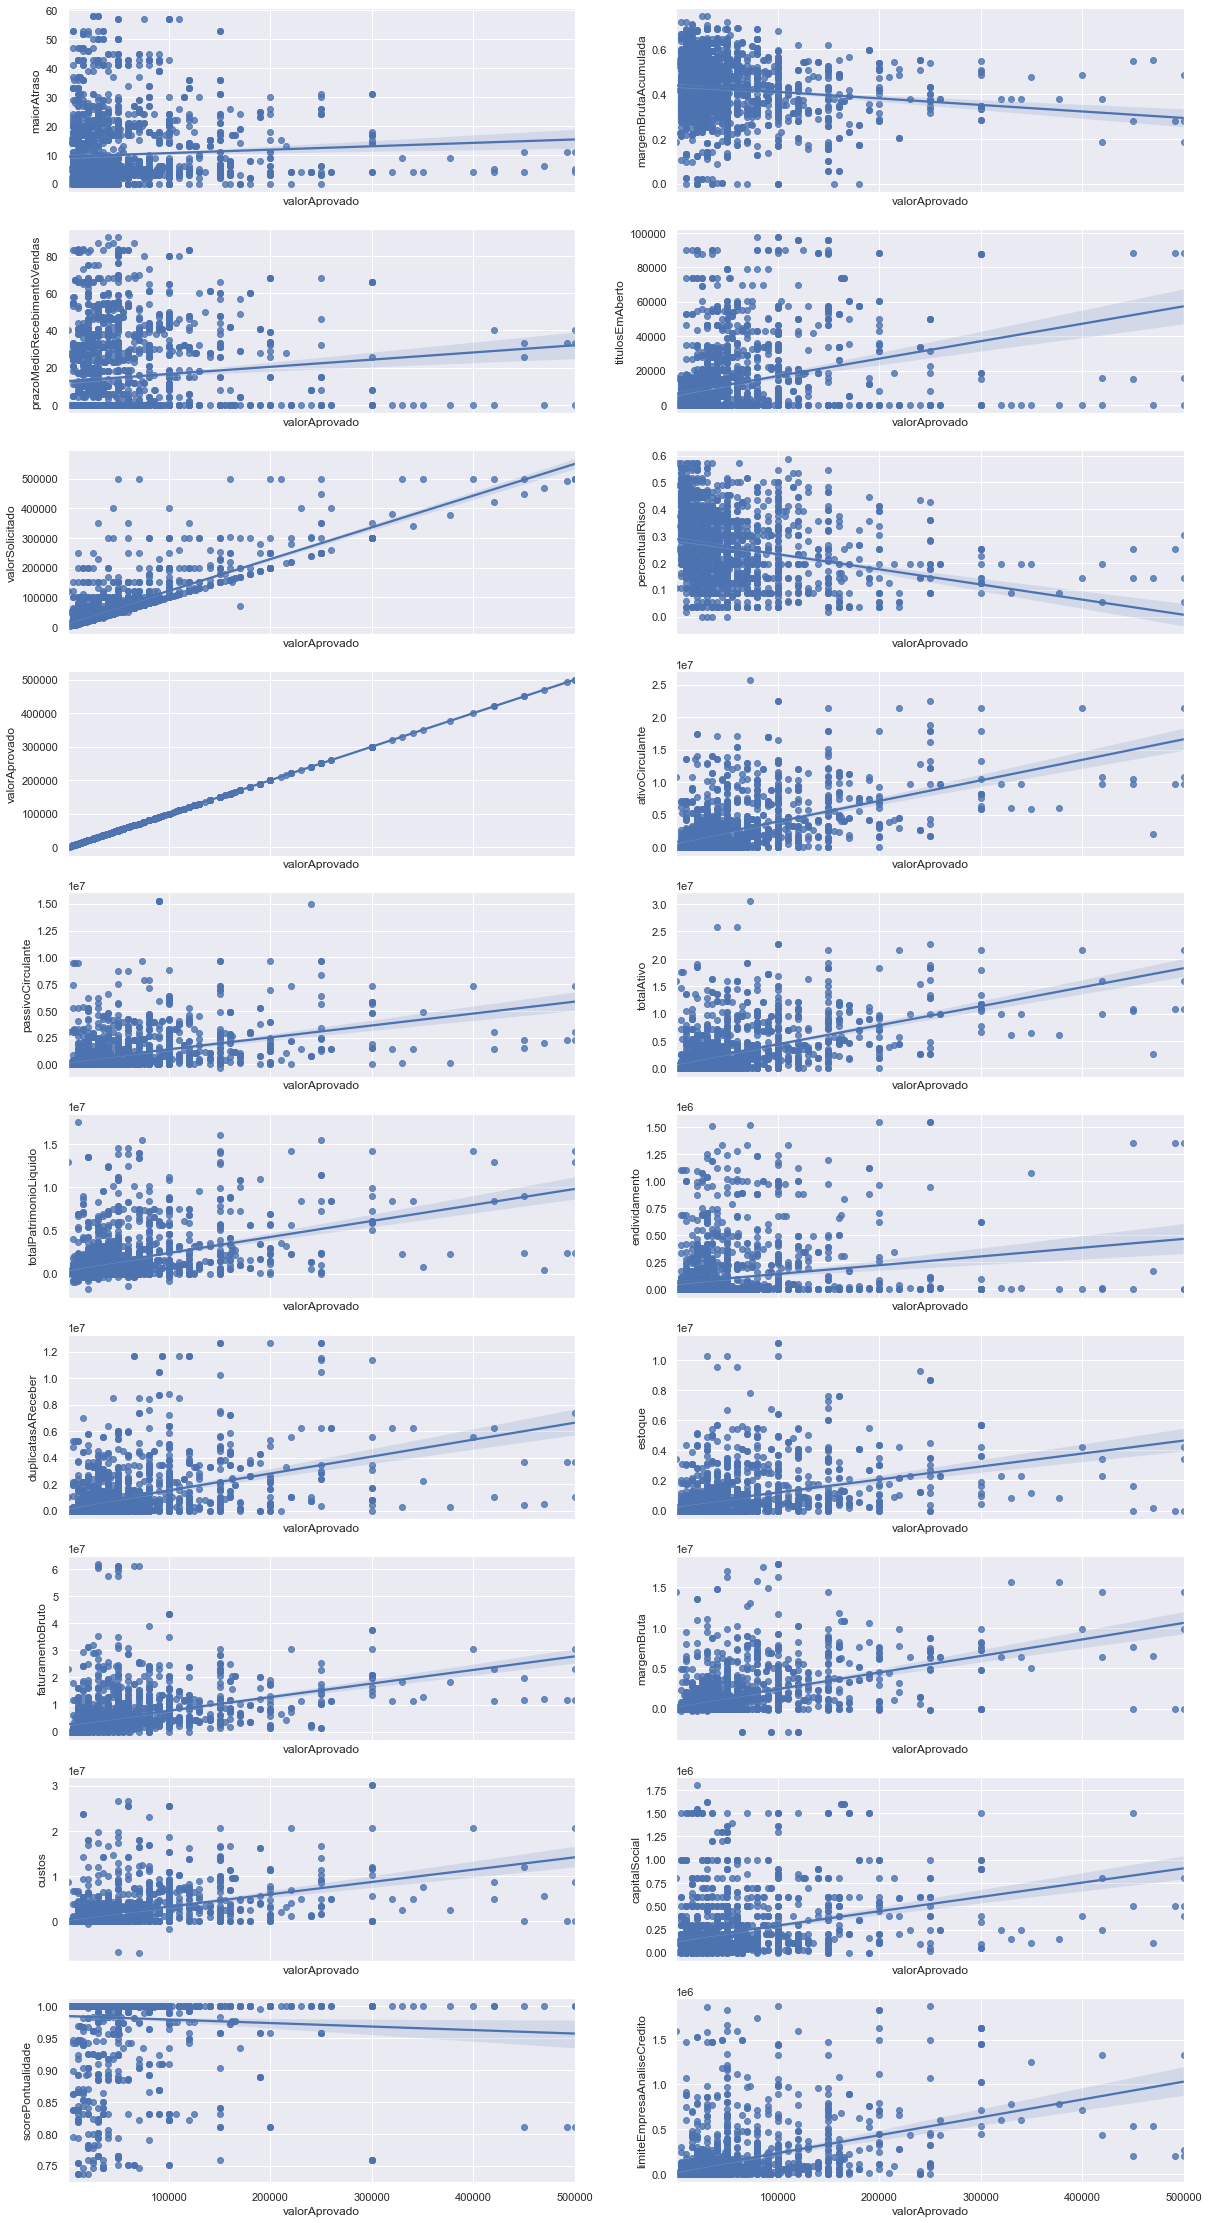

In [12]:
nc = 2
nl = 10
fig, axes = plt.subplots(nl, nc, sharex=True, figsize=(20,40))
coluna = 0
for x in range(10):
    for y in range(2):
        sns.regplot(x=df_num.valorAprovado, y=df_num.iloc[:,coluna], ax=axes[x,y])
        coluna += 1
    
plt.show()    

<h1>
Mapa de correlações
</h1>

<AxesSubplot:>

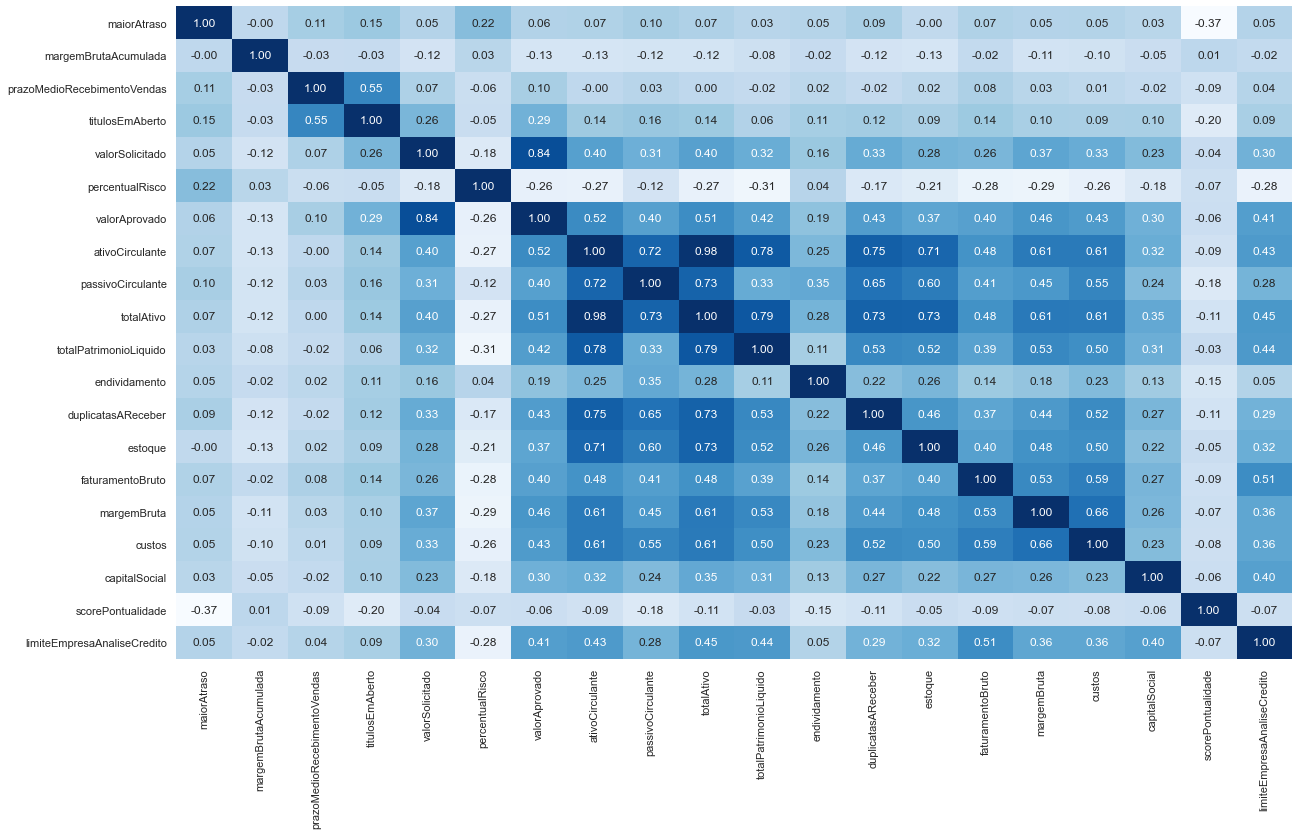

In [13]:
fig = plt.figure(figsize=(20,12))
sns.heatmap(df_num.corr(), cmap='Blues', annot=True, cbar=False, fmt='0.2f')

<h2>
Retiramos abaixo algumas variáveis muito correlacionadas ou com muito pouca tendência positiva ou negativa no gráfico linear.
</h2>

In [14]:
#df_num = df_num.drop(['endividamento', 'scorePontualidade', 'margemBrutaAcumulada', 'ativoCirculante', 'passivoCirculante', 'duplicatasAReceber'], axis=1)
df_lin = df_num.drop(['ativoCirculante', 'scorePontualidade', 'maiorAtraso', 'totalAtivo'], axis=1)

In [15]:
df_lin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199 entries, 0 to 6009
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   margemBrutaAcumulada         2199 non-null   float64
 1   prazoMedioRecebimentoVendas  2199 non-null   float64
 2   titulosEmAberto              2199 non-null   float64
 3   valorSolicitado              2199 non-null   float64
 4   percentualRisco              2199 non-null   float64
 5   valorAprovado                2199 non-null   float64
 6   passivoCirculante            2199 non-null   float64
 7   totalPatrimonioLiquido       2199 non-null   float64
 8   endividamento                2199 non-null   float64
 9   duplicatasAReceber           2199 non-null   float64
 10  estoque                      2199 non-null   float64
 11  faturamentoBruto             2199 non-null   float64
 12  margemBruta                  2199 non-null   float64
 13  custos            

<h2>
Dividimos a base entre Treino e Teste com 20% para o Teste.
</h2>

In [16]:
x = df_lin.drop('valorAprovado', axis=1)
y = df_lin.valorAprovado

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<h1>
Calculo do modelo de Regressão Linear.<BR>
</h1>
<h2>
Análise do modelos por diversas métricas.
</h2>

In [17]:
lm = LinearRegression(normalize=True)
linear = lm.fit(x_train, y_train)
y_pred = linear.predict(x_test)
print(f"R2 score do treino: {round(linear.score(x_train, y_train), 4)}")
print(f"R2 score do teste: {round(linear.score(x_test, y_test), 4)}")
print(f"MAE do teste: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"RMSE do teste: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")

R2 score do treino: 0.7697
R2 score do teste: 0.7948
MAE do teste: 15252.53
RMSE do teste: 24372.79


<h2>
Teste do modelo em alguns dados com o seu erro.
</h2>

In [18]:
index_amostra = [15, 27, 76, 152, 212, 243, 289, 314, 356, 412]
for x in index_amostra:
    amostra = np.array(x_test.iloc[x,:]).reshape(1,-1)
    previsao = linear.predict(amostra)
    print(f"Previsão: {round(previsao[0],2)} x Real: {y_test.iloc[x]} - erro {round(y_test.iloc[x] - round(previsao[0],2),2)}")

Previsão: 57815.17 x Real: 75000.0 - erro 17184.83
Previsão: 107173.03 x Real: 100000.0 - erro -7173.03
Previsão: 82617.27 x Real: 100000.0 - erro 17382.73
Previsão: 6770.47 x Real: 10000.0 - erro 3229.53
Previsão: 137823.82 x Real: 60000.0 - erro -77823.82
Previsão: 16047.78 x Real: 15000.0 - erro -1047.78
Previsão: 58421.79 x Real: 30000.0 - erro -28421.79
Previsão: 57104.87 x Real: 30000.0 - erro -27104.87
Previsão: 63308.38 x Real: 50000.0 - erro -13308.38
Previsão: 90563.11 x Real: 90000.0 - erro -563.11


<h2>
Gráfico da distribuição dos resultados originais e previstos pelo modelo.
</h2>

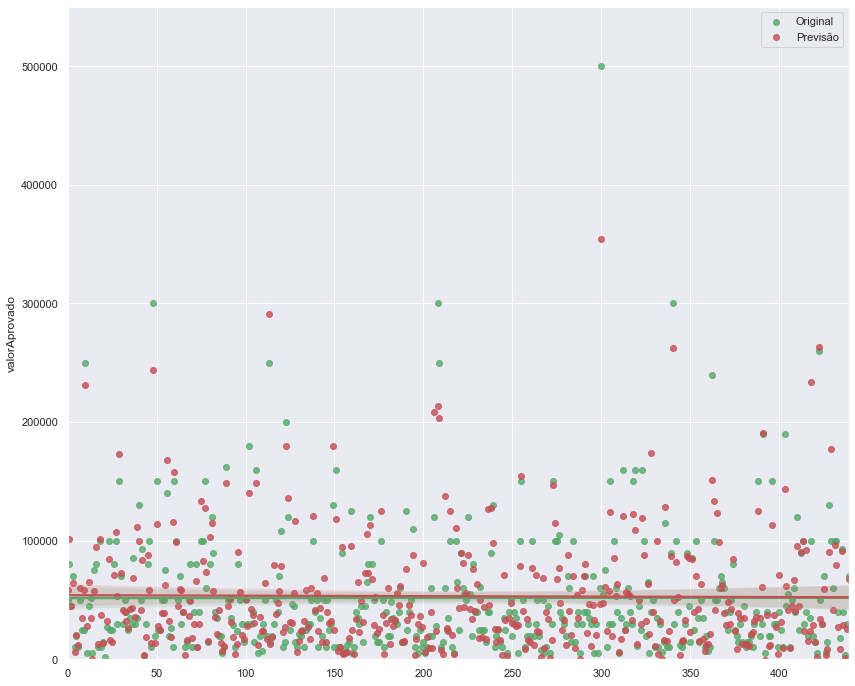

In [19]:
fig = plt.figure(figsize=(14,12))
xrange = list(range(len(y_test)))
sns.regplot(x=xrange, y=y_test, color='g', truncate=True, label='Original')
sns.regplot(x=xrange, y=y_pred, color='r', truncate=True, label='Previsão')
plt.legend()
plt.ylim(0,550000)
plt.show()

<h2>
Aproveitamos para testar mais dois modelos de regressão linear.<BR>
Não houve melhora em nenhum deles.
</h2>

In [20]:
ridge = Ridge()
lin_rdg = ridge.fit(x_train, y_train)
y_pred = lin_rdg.predict(x_test)
print(f"R2 score do treino: {round(lin_rdg.score(x_train, y_train), 4)}")
print(f"R2 score do teste: {round(lin_rdg.score(x_test, y_test), 4)}")
print(f"MAE do teste: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"RMSE do teste: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")

R2 score do treino: 0.7697
R2 score do teste: 0.7947
MAE do teste: 15250.65
RMSE do teste: 24374.33


In [21]:
elastic = ElasticNet()
lin_elastic = elastic.fit(x_train, y_train)
y_pred = lin_elastic.predict(x_test)
print(f"R2 score do treino: {round(lin_elastic.score(x_train, y_train), 4)}")
print(f"R2 score do teste: {round(lin_elastic.score(x_test, y_test), 4)}")
print(f"MAE do teste: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"RMSE do teste: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")

R2 score do treino: 0.7681
R2 score do teste: 0.7921
MAE do teste: 15379.05
RMSE do teste: 24529.28


<h1>MLP</h1>
<h2>
Vamos implementar uma rede neural com o intuito de conseguir uma melhor previsão em relação ao resultado da regressão linear.<BR>
</h2->

<h2>
Vamos usar a base completa, sem retirar dados correlacionados, pois o modelo de MLP é mais robusto a este problema e quanto mais dados melhor para ele.<BR>
Dividimos a base entre Treino e Teste com 20% para o Teste<BR>
Vamos usar a base de Teste para a validação pois não temos muitos dados para este treinamento.<BR>

In [44]:
x = df_num.drop('valorAprovado', axis=1)
y = df_num.valorAprovado

ssc = StandardScaler()
x_ssc = ssc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_ssc, y, test_size=0.2, random_state=42)

In [23]:
x.shape

(2199, 19)

<h2>
Criação do Modelo de MLP
</h2>

In [24]:
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

<h2>
Treinamento do modelo com checkpoint para salvar o modelo com menor MAE (achamos mais robusto a outliers que o RMSE).
</h2>

In [25]:
checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex3.hdf5', verbose=1, save_best_only=True, monitor='val_mae')

model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae'])
#history = model.fit(x_train, y_train, epochs=250, batch_size=16, validation_split=0.1, callbacks=[checkpointer])
history = model.fit(x_train, y_train, epochs=250, batch_size=16, validation_data=(x_test, y_test), callbacks=[checkpointer])

Epoch 1/250
 93/110 [========================>.....] - ETA: 0s - loss: 45166.8125 - mse: 4810442240.0000 - mae: 45166.8125
Epoch 00001: val_mae improved from inf to 26022.60547, saving model to .\modelo_mlp_ex3.hdf5
110/110 [==============================] - 1s 6ms/step - loss: 42279.0391 - mse: 4433993728.0000 - mae: 42279.0391 - val_loss: 26022.6055 - val_mse: 1556123136.0000 - val_mae: 26022.6055
Epoch 2/250
 96/110 [=========================>....] - ETA: 0s - loss: 24857.8613 - mse: 1725033472.0000 - mae: 24857.8613
Epoch 00002: val_mae improved from 26022.60547 to 20843.94336, saving model to .\modelo_mlp_ex3.hdf5
110/110 [==============================] - 1s 5ms/step - loss: 24133.6875 - mse: 1631338496.0000 - mae: 24133.6875 - val_loss: 20843.9434 - val_mse: 895912128.0000 - val_mae: 20843.9434
Epoch 3/250
105/110 [===========================>..] - ETA: 0s - loss: 20736.2695 - mse: 1091247104.0000 - mae: 20736.2695
Epoch 00003: val_mae improved from 20843.94336 to 18258.90039, s

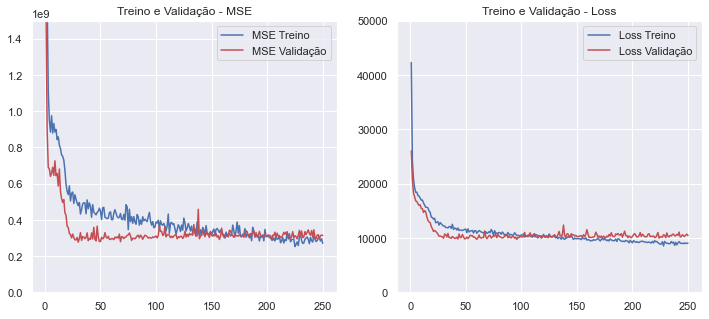

In [26]:
plot_history(history)

<h2>
Carregando o melhor modelo.
</h2>

In [27]:
model = load_model("./modelo_mlp_ex3.hdf5")

<h2>
Cálculo de diversas métricas para comparar com a regressão linear.
</h2>

In [28]:
y_pred = model.predict(x_test)
y_p_train = model.predict(x_train)

print(f"R2 score do treino: {round(r2_score(y_train, y_p_train), 4)}")
print(f"R2 score do teste: {round(r2_score(y_test, y_pred), 4)}")
print(f"MAE do teste: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"RMSE do teste: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")


R2 score do treino: 0.9116
R2 score do teste: 0.8966
MAE do teste: 9725.91
RMSE do teste: 17298.37


<h1>
Nosso modelo de MLP performou bem melhor que a regressão linear!
</h1h>

<h2>
Teste do modelo em alguns dados com o seu erro.
</h2>

In [29]:
index_amostra = [15, 27, 76, 152, 212, 243, 289, 314, 356, 412]
for x in index_amostra:
    amostra = x_test[x].reshape(1,-1)
    previsao = model.predict(amostra)
    print(f"Previsão: {previsao[0][0]} x Real: {y_test.iloc[x]} - erro {y_test.iloc[x] - previsao[0][0]}")

Previsão: 73946.59375 x Real: 75000.0 - erro 1053.40625
Previsão: 94403.828125 x Real: 100000.0 - erro 5596.171875
Previsão: 86811.0703125 x Real: 100000.0 - erro 13188.9296875
Previsão: 11580.041015625 x Real: 10000.0 - erro -1580.041015625
Previsão: 149678.8125 x Real: 60000.0 - erro -89678.8125
Previsão: 19817.33984375 x Real: 15000.0 - erro -4817.33984375
Previsão: 32659.81640625 x Real: 30000.0 - erro -2659.81640625
Previsão: 50791.390625 x Real: 30000.0 - erro -20791.390625
Previsão: 44445.6953125 x Real: 50000.0 - erro 5554.3046875
Previsão: 85218.25 x Real: 90000.0 - erro 4781.75


<h2>
Gráfico da distribuição dos resultados originais e previstos pelo modelo.
</h2>

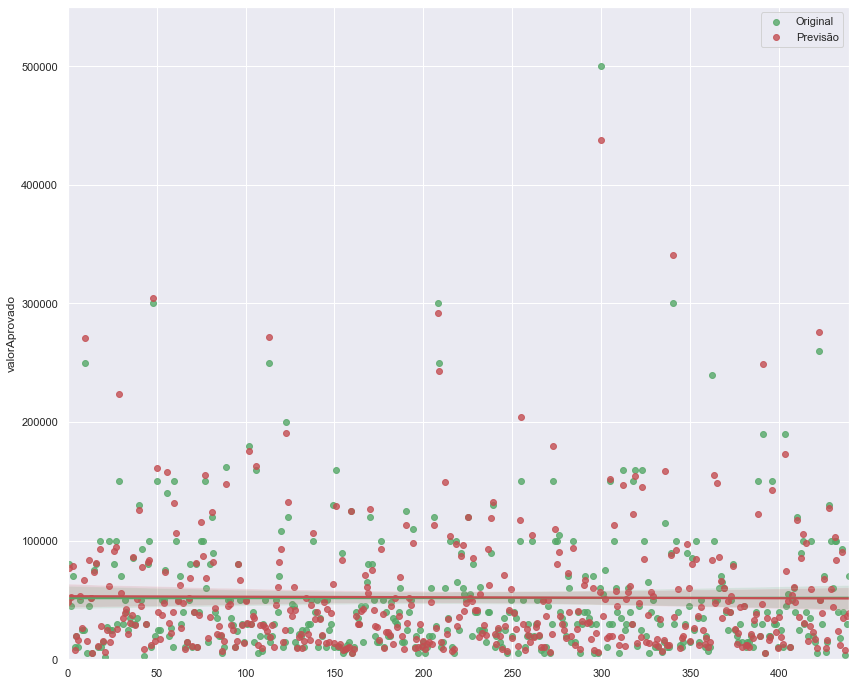

In [30]:
fig = plt.figure(figsize=(14,12))
xrange = list(range(len(y_test)))
sns.regplot(x=xrange, y=y_test, color='g', truncate=True, label='Original')
sns.regplot(x=xrange, y=y_pred, color='r', truncate=True, label='Previsão')
plt.legend()
plt.ylim(0,550000)
plt.show()